# FrameNet Data Importer
This notebook walks through importing data from [FrameNet's](https://framenet.icsi.berkeley.edu/fndrupal/) XML format into a more analysis-friendly Pandas DataFrame (or JSON or CSV). It also computes some summary statistics and some exploratory analysis on the data.

## Import necessary libraries

In [1]:
import os
import xml.etree.ElementTree as ET

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")

## Library functions

In [2]:
def parse_xml(directory, file_name):
    """
    Parses XML from FrameNet, given a file's directory and filename
    
    Inputs:
        directory (string): path to directory where XML file is stored.
        file_name (string): file name to parse.
        
    Output:
        (array of dict): an array with dictionaries containing the corpus name, the current document name,
            a full sentence, a word, and the assoicated part of speech and semantic frame for that word.
    """
    # all files have a name space
    ns = { 'framenet': "http://framenet.icsi.berkeley.edu" }
    
    # get the element tree of the xml file
    root = ET.parse(os.path.join(directory, file_name)).getroot()
    
    # setup output info
    output = []
    corpus_name, document_name = file_name.replace(".xml", "").split("__")
    
    # work through each sentence and setup output
    for sentence in root.findall('framenet:sentence', ns):
        # get sentence
        text = sentence.find('framenet:text', ns)
        
        # get all annotations_sets for the sentence
        for annotation_set in sentence.findall('framenet:annotationSet', ns):
            # check if annotation set has a lexical unit (luName) and a frame name (frameName) attribute
            attributes = annotation_set.attrib
            if "luName" in attributes and "frameName" in attributes:
                # get lexical unit, phrase type, and frame name
                lexical_unit, phrase_type = attributes["luName"].split(".")
                frame_name = attributes["frameName"]
                
                # convert phrase_type to readable one
                phrase_type_lookup = {
                    "n": "noun",
                    "a": "adjective",
                    "v": "verb",
                    "adv": "adverb",
                    "prep": "prepositional",
                    "c": "clause",
                    "art": "art",
                    "num": "quantifier",
                    "idio": "idiom",
                    "scon": "subordinate clause with subordinating conjunction"
                }
                
                # add to output
                output.append({
                    "corpus": corpus_name,
                    "document": document_name,
                    "sentence": text.text.strip(),
                    "word": lexical_unit.strip(),
                    "phrase_type": phrase_type_lookup[phrase_type.strip()],
                    "semantic_frame": frame_name.strip()
                })
    
    return output
                

## Parse data into a Pandas DataFrame, and save out

In [3]:
DATA_DIR = "./fndata/fulltext"

# parse all data
parsed_files = []
for root, dirs, files in os.walk(DATA_DIR):
    for file in tqdm(files):
        if file.endswith(".xml"):
            parsed_files += parse_xml(root, file)

# convert list to dataframe
parsed_files_df = pd.DataFrame(parsed_files)
parsed_files_df

,corpus,document,sentence,word,phrase_type,semantic_frame
0,LUCorpus-v0.3,enron-thread-159550,"I have completed the invoices for April, May a...",complete,verb,Activity_finish
1,LUCorpus-v0.3,enron-thread-159550,"I have completed the invoices for April, May a...",May,noun,Calendric_unit
2,LUCorpus-v0.3,enron-thread-159550,"I have completed the invoices for April, May a...",June,noun,Calendric_unit
3,LUCorpus-v0.3,enron-thread-159550,"I have completed the invoices for April, May a...",month,noun,Calendric_unit
4,LUCorpus-v0.3,enron-thread-159550,"I have completed the invoices for April, May a...",total,noun,Amounting_to
...,...,...,...,...,...,...
28936,ANC,IntroJamaica,Jamaica is an island with a strong personality...,strong,adjective,Level_of_force_exertion
28937,ANC,IntroJamaica,Jamaica is an island with a strong personality...,wait,verb,Waiting
28938,ANC,IntroJamaica,Jamaica is an island with a strong personality...,wing,noun,Building_subparts
28939,ANC,IntroJamaica,It comes out to meet you .,come,verb,Arriving


In [4]:
# create output directory if needed
OUTPUT_DIR = "./parsed_data"
OUTPUT_FILE = "parsed_framenet"
OUTPUT_FILE_DIR = os.path.join(OUTPUT_DIR, OUTPUT_FILE)

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# save as pickle
parsed_files_df.to_pickle(OUTPUT_FILE_DIR + ".p")

# save as json
parsed_files_df.to_json(OUTPUT_FILE_DIR  + ".json", orient="records", indent=4)

# save as csv
parsed_files_df.to_csv(OUTPUT_FILE_DIR + ".csv", index=False)

## Usage of DataFrame

### Load in data

In [5]:
# read in data from pickle, json, or csv file
data_df = pd.read_pickle(OUTPUT_FILE_DIR + ".p")
# data_df = pd.read_json(OUTPUT_FILE_DIR  + ".json")
# data_df = pd.read_csv(OUTPUT_FILE_DIR  + ".csv")

# view first 5 rows of DataFrame
data_df.head(5)

,corpus,document,sentence,word,phrase_type,semantic_frame
0,LUCorpus-v0.3,enron-thread-159550,"I have completed the invoices for April, May a...",complete,verb,Activity_finish
1,LUCorpus-v0.3,enron-thread-159550,"I have completed the invoices for April, May a...",May,noun,Calendric_unit
2,LUCorpus-v0.3,enron-thread-159550,"I have completed the invoices for April, May a...",June,noun,Calendric_unit
3,LUCorpus-v0.3,enron-thread-159550,"I have completed the invoices for April, May a...",month,noun,Calendric_unit
4,LUCorpus-v0.3,enron-thread-159550,"I have completed the invoices for April, May a...",total,noun,Amounting_to


### See unique entries of a column

In [6]:
# show all uniqe corpus names
data_df["corpus"].unique()

array(['LUCorpus-v0.3', 'ANC', 'WikiTexts', 'NTI', 'PropBank',
       'Miscellaneous', 'KBEval'], dtype=object)

In [7]:
# show all uniqe document names
data_df["document"].unique()

array(['enron-thread-159550', 'HistoryOfLasVegas', 'Fires_5',
       'acquisition.n', 'Kazakhstan', 'Fires_4', '602CZL285-1',
       'ENRON-pearson-email-25jul02', 'Fires_6', '20000410_nyt-NEW',
       'AetnaLifeAndCasualty', '20000415_apw_eng-NEW', 'Fires_7',
       'Iran_Introduction', 'NorthKorea_NuclearCapabilities',
       'tradeBalance020417', '110CYL200', 'chapter1_911report', 'Fires_3',
       'WMDNews_042106', 'AFGP-2002-600002-Trans', 'IranRelatedQuestions',
       'LomaPrieta', 'Fires_2', 'SouthAfrica_Introduction',
       'WMDNews_062606', 'ElectionVictory', 'cycorp', 'SemAnno_1',
       'someone.n', 'Russia_Introduction', 'Fires_1', 'Fires_10',
       'workAdvances', 'Tiger_Of_San_Pedro',
       'PolemicProgressiveEducation', 'wsj_2465',
       'CNN_AARONBROWN_ENG_20051101_215800.partial-NEW',
       '20000424_nyt-NEW', 'lcch', 'invoice.n', 'LibyaCountry1',
       '112C-L013', 'journal_christine', 'parc', '110CYL070',
       'StephanopoulosCrimes', 'MIT', '110CYL072', 'Ira

In [8]:
# show all uniqe phrase types
data_df["phrase_type"].unique()

array(['verb', 'noun', 'adjective', 'adverb', 'prepositional', 'clause',
       'art', 'quantifier', 'idiom',
       'subordinate clause with subordinating conjunction'], dtype=object)

In [9]:
# show all uniqe semantic frames
data_df["semantic_frame"].unique()

array(['Activity_finish', 'Calendric_unit', 'Amounting_to', 'Waiting',
       'Verification', 'Desirability', 'Hearsay', 'Desiring',
       'Commerce_pay', 'Holding_off_on', 'Possession', 'Information',
       'Giving', 'Quantified_mass', 'Temporal_collocation', 'System',
       'Needing', 'Predicting', 'Money', 'Awareness', 'Experiencer_focus',
       'Intentionally_act', 'Expected_location_of_person',
       'Building_subparts', 'Judgment_direct_address', 'Work',
       'Speed_description', 'Attempt', 'Statement', 'Activity_done_state',
       'Opinion', 'Relative_time', 'Time_vector', 'Causation', 'Gizmo',
       'Proportional_quantity', 'Required_event', 'Telling',
       'Make_agreement_on_action', 'Having_or_lacking_access',
       'Fluidic_motion', 'Assistance', 'Getting', 'Taking_time',
       'Creating', 'Grasp', 'Supply', 'Being_necessary', 'Arriving',
       'Sending', 'Text', 'Capability', 'History', 'Duration_description',
       'Natural_features', 'Locale', 'Distributed_

### Selection of data

In [10]:
# get data from the ANC corpus
target_corpus = "ANC"
data_df.query("corpus == @target_corpus")

,corpus,document,sentence,word,phrase_type,semantic_frame
137,ANC,HistoryOfLasVegas,A Brief History,history,noun,History
138,ANC,HistoryOfLasVegas,A Brief History,brief,adjective,Duration_description
139,ANC,HistoryOfLasVegas,Early Habitation,early,adjective,Relative_time
140,ANC,HistoryOfLasVegas,The inhabited history of the Las Vegas Valley ...,valley,noun,Natural_features
141,ANC,HistoryOfLasVegas,The inhabited history of the Las Vegas Valley ...,area,noun,Locale
...,...,...,...,...,...,...
28936,ANC,IntroJamaica,Jamaica is an island with a strong personality...,strong,adjective,Level_of_force_exertion
28937,ANC,IntroJamaica,Jamaica is an island with a strong personality...,wait,verb,Waiting
28938,ANC,IntroJamaica,Jamaica is an island with a strong personality...,wing,noun,Building_subparts
28939,ANC,IntroJamaica,It comes out to meet you .,come,verb,Arriving


In [11]:
# get data from the ANC corpus with the "Building_subparts" semantic frame
target_corpus = "ANC"
target_semantic_frame = "Building_subparts"
data_df.query("corpus == @target_corpus and semantic_frame == @target_semantic_frame").head(5)

,corpus,document,sentence,word,phrase_type,semantic_frame
802,ANC,HistoryOfLasVegas,Several weeks later he was asked -- then order...,room,noun,Building_subparts
806,ANC,HistoryOfLasVegas,Several weeks later he was asked -- then order...,room,noun,Building_subparts
954,ANC,HistoryOfLasVegas,"Over 20,000 additional hotel rooms have been a...",room,noun,Building_subparts
11431,ANC,StephanopoulosCrimes,"Near the end of The War Room , Stephanopoulos ...",room,noun,Building_subparts
16490,ANC,110CYL069,In the short while since Goodwill helped him f...,room,noun,Building_subparts


### Iteration

In [12]:
# iterate over all rows and count number of words with noun phrase_type for each corpus
noun_count_dict = {corpus: 0 for corpus in data_df['corpus'].unique()}

for index, row in data_df.iterrows():
    if row['phrase_type'] == "noun":
        noun_count_dict[row["corpus"]] += 1

noun_count_dict

{'LUCorpus-v0.3': 1432,
 'ANC': 3770,
 'WikiTexts': 459,
 'NTI': 5146,
 'PropBank': 830,
 'Miscellaneous': 1448,
 'KBEval': 687}

In [13]:
# iterate over all documents in the ANC corpus, and count words with noun phrase type
noun_count_dict = {corpus: 0 for corpus in data_df.query("corpus == 'ANC'")['document'].unique()}

for index, row in data_df.query("corpus == 'ANC'").iterrows():
    if row['phrase_type'] == "noun":
        noun_count_dict[row["document"]] += 1

noun_count_dict

{'HistoryOfLasVegas': 361,
 '110CYL200': 41,
 'chapter1_911report': 16,
 '112C-L013': 82,
 'journal_christine': 45,
 '110CYL070': 33,
 'StephanopoulosCrimes': 53,
 '110CYL072': 25,
 '110CYL067': 61,
 'HistoryOfGreece': 406,
 'HistoryOfJerusalem': 335,
 '110CYL069': 82,
 'WhereToHongKong': 1527,
 '110CYL068': 67,
 'IntroOfDublin': 227,
 'EntrepreneurAsMadonna': 67,
 'IntroHongKong': 118,
 'WhatToHongKong': 39,
 'IntroJamaica': 185}

## Summary Stats
This section of the notebook has some high-level summary statistics for the parsed dataset

### Number of corpus and documents

In [14]:
print("Number of corpus: {n_corpus} | Number of documents: {n_docs}".format(n_corpus=len(parsed_files_df['corpus'].unique()),
                                                                            n_docs=len(parsed_files_df['document'].unique())))

Number of corpus: 7 | Number of documents: 102


In [15]:
print("Number of documents corpus")
parsed_files_df.groupby("corpus")["document"].nunique()

Number of documents corpus


corpus
ANC              19
KBEval            9
LUCorpus-v0.3    21
Miscellaneous    11
NTI              20
PropBank          6
WikiTexts        16
Name: document, dtype: int64

### Number of sentences

In [16]:
print("Total unique number of sentences: {0}\n\nNumber of sentences per corpus: ".format(len(parsed_files_df['sentence'].unique())))
parsed_files_df.groupby("corpus")["sentence"].nunique()

Total unique number of sentences: 4938

Number of sentences per corpus: 


corpus
ANC              1353
KBEval            436
LUCorpus-v0.3     601
Miscellaneous     732
NTI              1324
PropBank          325
WikiTexts         196
Name: sentence, dtype: int64

In [17]:
print("Descriptive stats of number of sentences per document")
parsed_files_df.groupby("document")["sentence"].nunique().describe()

Descriptive stats of number of sentences per document


count    102.000000
mean      48.735294
std       70.664586
min        1.000000
25%       12.000000
50%       29.000000
75%       58.000000
max      499.000000
Name: sentence, dtype: float64

### Semantic Frames

In [18]:
print("Number of unique frames: {0}".format(len(parsed_files_df['semantic_frame'])))

Number of unique frames: 28941


In [19]:
print("Descriptive stats of number of semantic frames per sentence")
parsed_files_df.groupby("sentence")["semantic_frame"].nunique().describe()

Descriptive stats of number of semantic frames per sentence


count    4938.000000
mean        5.254962
std         3.295641
min         1.000000
25%         3.000000
50%         5.000000
75%         7.000000
max        23.000000
Name: semantic_frame, dtype: float64

## Exploratory Data Analysis
This section of the notebook begins some exploratory analysis of the FrameNet data.

In [20]:
# create a dataset with all frames for each sentence
sentence_df = parsed_files_df.groupby(["corpus", "document", "sentence"]).agg({
    "word": lambda x: list(x.unique()),
    "phrase_type": lambda x: list(x.unique()),
    "semantic_frame": lambda x: list(x.unique()),
}).reset_index()

sentence_df

,corpus,document,sentence,word,phrase_type,semantic_frame
0,ANC,110CYL067,A robust economy helps by providing job opport...,"[economy, help, provide, job, opportunity, hon...","[noun, verb, adjective]","[Economy, Assistance, Supply, Being_employed, ..."
1,ANC,110CYL067,Because people want to work .,"[because, people, want, work]","[clause, noun, verb]","[Causation, People, Desiring, Being_employed]"
2,ANC,110CYL067,Because teaching a man to fish will keep him f...,"[teach, man, fish, feed, entire, keep]","[verb, noun, adjective]","[Education_teaching, People, Hunting, Ingestio..."
3,ANC,110CYL067,Because turning welfare recipients into tax pa...,"[because, turn]","[clause, verb]","[Causation, Cause_change]"
4,ANC,110CYL067,Coming to Goodwill was the first step toward m...,"[come, to, first, step, become, totally]","[verb, prepositional, adjective, noun, adverb]","[Arriving, Goal, Ordinal_numbers, Intentionall..."
...,...,...,...,...,...,...
4966,WikiTexts,oven.n,"In later periods , large communal ovens appear...",[oven],[noun],[Artifact]
4967,WikiTexts,oven.n,In what is now the Southwestern United States ...,[oven],[noun],[Artifact]
4968,WikiTexts,oven.n,Inorganic arsenic is also found in coke oven e...,[oven],[noun],[Artifact]
4969,WikiTexts,oven.n,"Most other anthropologists , however , oppose ...",[oven],[noun],[Artifact]


### Frame co-occurence and correlation matrix

In [21]:
frame_list = list(parsed_files_df["semantic_frame"].unique())
n_semantic_frames = len(frame_list)

semantic_frame_index = {x: i for i, x in enumerate(frame_list)}

frame_co_matrix = []
for index, row in sentence_df.iterrows():
    curr_row = [0 for i in range(0, n_semantic_frames)]
    for frame in row["semantic_frame"]:
        curr_row[semantic_frame_index[frame]] += 1
    
    frame_co_matrix.append(curr_row)

frame_co_matrix_unprocessed_df = pd.DataFrame(frame_co_matrix, columns=frame_list)
frame_co_matrix_df = frame_co_matrix_unprocessed_df.T.dot(frame_co_matrix_unprocessed_df)
np.fill_diagonal(frame_co_matrix_df.values, 0)
frame_co_matrix_df

,Activity_finish,Calendric_unit,Amounting_to,Waiting,Verification,Desirability,Hearsay,Desiring,Commerce_pay,Holding_off_on,...,Misdeed,Arraignment,Bail_decision,Entering_of_plea,Adjusting,Beyond_compare,Robbery,Forgiveness,Making_arrangements,Indicating
Activity_finish,0,7,1,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Calendric_unit,7,0,6,3,1,9,2,8,6,3,...,0,1,2,0,1,0,0,0,0,0
Amounting_to,1,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Waiting,0,3,0,0,1,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Verification,1,1,0,1,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Beyond_compare,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Robbery,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Forgiveness,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Making_arrangements,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
frame_co_pairwise_dict = {}
for 

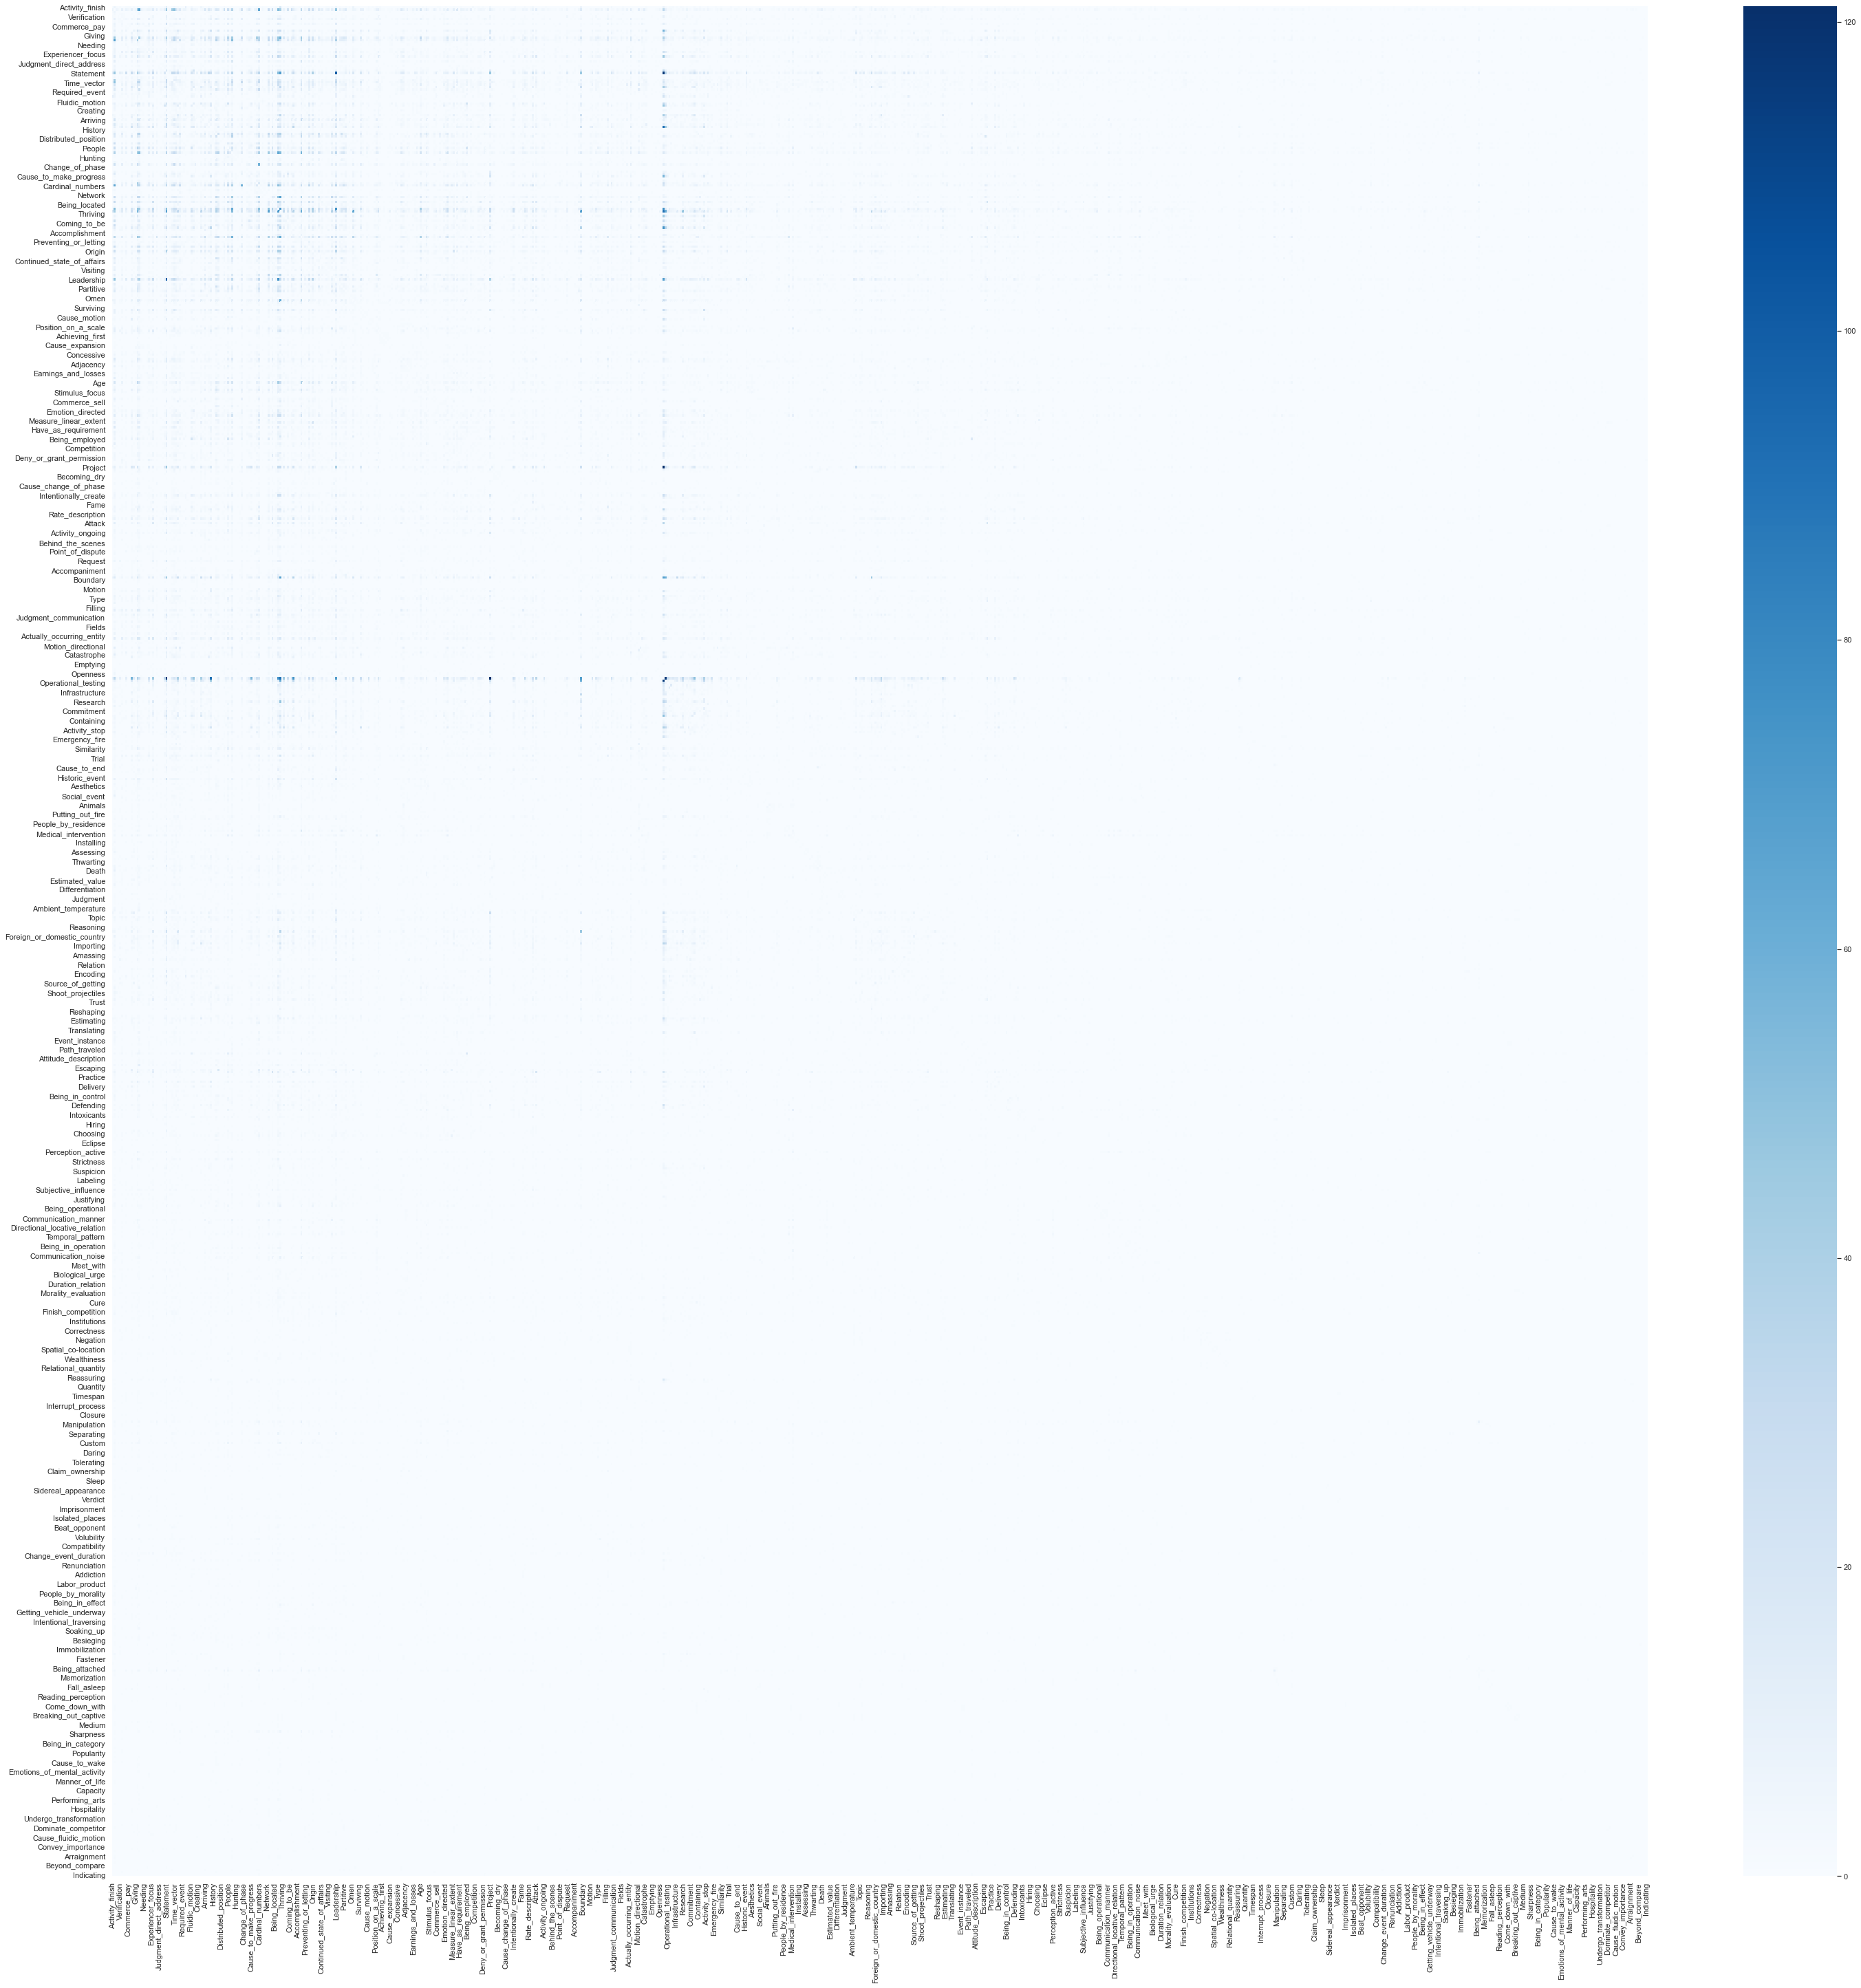

In [22]:
f, ax = plt.subplots(figsize=(50, 50))
sns.heatmap(frame_co_matrix_df, cmap="Blues")

### Frame intersections